# Задача 1
### Плюснин Павел 578 / plyusnin.pa@phystech.edu

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np

Считаем наши данные, преобразуем их к удобному формату

In [2]:
#такое извращенское считывание, т.к в исходном файле не постоянный sep
lines = []
with open("students.txt") as file:
    for line in file:
        lines.append(line.split())
data = pd.DataFrame(lines[1:-1], columns=lines[0])

In [3]:
data.head()

,Time,Student,Score
0,Before,a,65
1,Before,b,75
2,Before,c,86
3,Before,d,69
4,Before,e,60


In [4]:
merged_data = data[data.Time == "Before"].merge(data[data.Time == "After"], on="Student")[["Student", "Score_x", "Score_y"]]

In [5]:
merged_data[["Score_x", "Score_y"]] = merged_data[["Score_x", "Score_y"]].apply(pd.to_numeric)

In [6]:
merged_data["delta"] = merged_data.Score_y - merged_data.Score_x
merged_data

,Student,Score_x,Score_y,delta
0,a,65,77,12
1,b,75,98,23
2,c,86,92,6
3,d,69,77,8
4,e,60,65,5
5,f,81,77,-4
6,g,88,100,12
7,h,53,73,20
8,i,75,93,18
9,j,73,75,2


Populating the interactive namespace from numpy and matplotlib


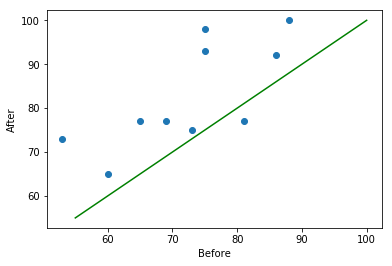

Text(0.5,1,'qq-plot')

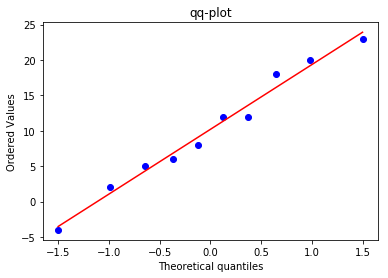

In [7]:
%pylab inline
plt.scatter(merged_data['Score_x'].values, merged_data['Score_y'].values)
plt.xlabel('Before')
plt.ylabel('After')
plt.plot(np.linspace(55, 100, 50), np.linspace(55, 100, 50), "g")
plt.show()

st.probplot(merged_data.delta, plot=plt)
plt.title("qq-plot")

Применим всевозможные пройденные методы, которые можно использовать к данной задаче. В дальнейшем, сделаем выводы, а также решим, какой метод целесообразнее всего было использовать

## Непараметрические гипотезы
$H_0$: среднее не изменилось  
$H_1$: среднее увеличилось (не изменилось)  
Смысл среднего в каждом тесте немного свой (ср. арифметическое, медиана...)

### Одновыборочный критерий знаков

In [8]:
from statsmodels.stats.descriptivestats import sign_test

In [9]:
sign_test(merged_data.delta)

(4.0, 0.021484374999999997)

In [10]:
st.binom_test(sum(merged_data.delta > 0), merged_data.shape[0]) #очевидно, что это то же самый тест, что и выше)))

0.021484374999999997

### Критерий знаковых рангов Уилкоксона

In [11]:
st.wilcoxon(merged_data.Score_x, merged_data.Score_y)

WilcoxonResult(statistic=2.0, pvalue=0.00929822320829811)

### Двухвыборочный перестановочный критерий

In [12]:
from permute.core import two_sample
two_sample(merged_data.Score_x, merged_data.Score_y,  alternative='less') 
    #односторонняя альтернатива (приоритетно, т.к вряд ли наше лекарство вредит...

(0.031159999999999966, -10.200000000000003)

In [13]:
    #...хотя всякое бывает
two_sample(merged_data.Score_x, merged_data.Score_y,  alternative='two-sided') 

(0.0632600000000001, -10.200000000000003)

а вот уже при двусторонней гипотезе не можем отвергнуть нулевую гипотезу на 0.95

## Параметрические гипотезы
Т.к тут мы будем предполагать нормальность выборки, сперва надо проверить это наше вольное предположение

#### Проверка на нормальность

In [14]:
st.shapiro(merged_data.delta)

(0.9754937887191772, 0.9365949630737305)

In [15]:
st.jarque_bera(merged_data.delta)

(0.36571563847142596, 0.8328865677677046)

Получили достаточно большой p_value для теста Шапиро-Уилки и Харке-Бера, гипотезу о нормальности не отвергаем (на qq-графике тоже все хорошо, смотри выше)

### t-критерий Стьюдента

In [16]:
st.ttest_rel(merged_data.Score_x, merged_data.Score_y)

Ttest_relResult(statistic=-3.808374649652914, pvalue=0.004163495155629837)

In [17]:
st.ttest_1samp(merged_data.delta, 0) #очевидно, что это то же самое, что и выше))))

Ttest_1sampResult(statistic=3.808374649652914, pvalue=0.004163495155629837)

### Доверительный интервал для средней разности при помощи бутстрепа

In [18]:
from arch.bootstrap import IIDBootstrap
bs = IIDBootstrap(merged_data.delta)
bs.conf_int(np.mean, 200, method='bca')

array([[ 5.81100549],
       [14.91545838]])

### Доверительный интервал с равными вероятностями по разные стороны от медианы

In [19]:
st.t.interval(0.95, len(merged_data.delta)-1, loc=np.mean(merged_data.delta), scale=st.sem(merged_data.delta))

(4.141246546722754, 16.258753453277244)

# Выводы
Получили, что все применные тесты отвергли нулевую гипотезу о том, что курс не влияет на финансовую грамотность на уровне значимости 0.95. Кр.знаковых рангов Уилкоксона и t-критерий Стьюдента вообще позволяют отвергнуть гипотезу на уровне значимости 0.99. Собственно, эти два критерия с самого начала было целесообразнее всего применять (Двухвыборочный перестановочный критерий тоже можно, но считается он гораздо дольше)  
Критерий знаков немного нецелесообразно было использовать, ведь мы знаем точные дельты, этот критерий терял много информации в нашем случае.  
Доверительный интервал на основе бутстрепа говорит, что $\bar{\Delta} \sim [5.8; 14.9]$  

Оценим размер эффекта Cohen's d

In [20]:
def cohens_d(a, b):
    len_a = len(a)
    len_b = len(b)
    s1_2 = np.std(a, ddof=1) ** 2
    s2_2 = np.std(b, ddof=1) ** 2
    
    s = np.sqrt( ((len_a - 1)*s1_2 + (len_b-1)*s2_2)/(len_a + len_b - 2) )
    d = (np.mean(a) - np.mean(b)) / s
    return d

In [21]:
cohens_d(merged_data.Score_x, merged_data.Score_y)

-0.8828678212381178

Размер эффекта по модулю больше 0.8, по таблице соответствует большому (Large, 4/6)